# Decision Tree Classifier Implementation

This is an implementation of Decision Tree Classifier from scratch.

## Tools

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
from math import log2

## Tree Node Class


In [2]:
class Node:
  def __init__(self, left=None, right=None, info_gain=None, feature_index=None, threshold=None, value=None):
    self.left = left
    self.right = right
    self.info_gain = info_gain
    self.feature_index = feature_index
    self.threshold = threshold
    self.value = value

The `Node` class represents a single node in a decision tree structure. It is used to store information about a decision point (for internal nodes) or a predicted value (for leaf nodes). This class is typically part of a decision tree implementation for machine learning tasks such as classification or regression.

### Parameters
- **left** (*Node, optional*): The left child node of the current node. Defaults to `None`. Used in internal nodes to reference the subtree for cases where the feature value is less than or equal to the threshold.
- **right** (*Node, optional*): The right child node of the current node. Defaults to `None`. Used in internal nodes to reference the subtree for cases where the feature value exceeds the threshold.
- **info_gain** (*float, optional*): The information gain achieved by splitting the data at this node. Defaults to `None`. Typically used in internal nodes to quantify the quality of the split.
- **feature_index** (*int or str, optional*): The index of the feature used for splitting the data at this node. Defaults to `None`. Only applicable to internal nodes.
- **threshold** (*float, optional*): The threshold value for the feature used to split the data. Defaults to `None`. Only applicable to internal nodes.
- **value** (*any, optional*): The predicted value or class label stored in the node. Defaults to `None`. Typically used in leaf nodes to represent the output of the decision tree.

### Usage
This class is designed to be used as a building block for constructing a decision tree. Internal nodes will have `feature`, `threshold`, and `info_gain` defined, along with `left` and `right` child nodes. Leaf nodes will have a `value` defined but no children or split criteria.

## Decision Tree Class

In [3]:
class DecisionTreeClassifier:
    def __init__(self, max_depth=7, min_samples_split=10):
        """Initialize the decision tree with hyperparameters."""
        self.max_depth = max_depth  # Maximum depth of the tree
        self.min_samples_split = min_samples_split  # Minimum samples required to split a node
        self.root = None  # Root node of the tree, starts as None

    def fit(self, X, y):
        """Train the decision tree using the input features X and target y."""
        self.root = self.build_tree(X, y)  # Build the tree and set the root

    def predict(self, X):
        """Make predictions for each sample in X."""
        if self.root is None:
            raise ValueError("Model has not been trained. Please call 'fit' method first.")
        # Return predictions by traversing the tree for each sample
        return [self.make_prediction(x, self.root) for x in X]

    def make_prediction(self, x, node):
        """Recursively traverse the tree to make a prediction for a single sample."""
        if node.value is not None:  # Leaf node reached
            return node.value
        # Decide which subtree to follow based on the feature value
        if x[node.feature_index] <= node.threshold:
            return self.make_prediction(x, node.left)
        else:
            return self.make_prediction(x, node.right)

    def print_tree(self):
        """Print the structure of the decision tree."""
        self.print_tree_helper(self.root, 0)  # Start from the root with depth 0

    def print_tree_helper(self, node, depth):
        """Helper method to recursively print the tree with indentation."""
        if node is None:
            return
        indent = " " * depth  # Indentation for visual hierarchy
        if node.value is not None:  # Leaf node
            print(f"{indent}Predict: {node.value}")
        else:  # Internal node
            print(f"{indent}X[{node.feature_index}] <= {node.threshold} -> True:")
            self.print_tree_helper(node.left, depth + 1)
            print(f"{indent}X[{node.feature_index}] > {node.threshold} -> False:")
            self.print_tree_helper(node.right, depth + 1)

    def build_tree(self, X, y, depth=0):
        """Recursively build the decision tree."""
        m, n = X.shape  # Number of samples (m) and features (n)
        is_pure = len(np.unique(y)) == 1  # Check if all labels are the same

        # Base case: stop if max depth reached, data is pure, or too few samples
        if depth >= self.max_depth or is_pure or m < self.min_samples_split:
            majority_class = self.compute_output(y)  # Assign majority class to leaf
            return Node(value=majority_class)

        # Find the best split and recursively build left and right subtrees
        best_split = self.get_best_split(X, y)
        left_indices = best_split['left']
        right_indices = best_split['right']
        left_subtree = self.build_tree(X[left_indices, :], y[left_indices], depth + 1)
        right_subtree = self.build_tree(X[right_indices, :], y[right_indices], depth + 1)

        # Return a node with the split details and subtrees
        return Node(left=left_subtree,
                    right=right_subtree,
                    info_gain=best_split['info_gain'],
                    feature_index=best_split['feature_index'],
                    threshold=best_split['threshold'])

    def get_best_split(self, X, y):
        """Find the best feature and threshold to split the data."""
        _, n = X.shape
        best_split = {
            'info_gain': float('-inf'),
            'threshold': None,
            'feature_index': None,
            'left': None,
            'right': None
        }

        # Iterate over all features and their unique values as potential thresholds
        for feature_index in range(n):
            feature_values = X[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                # Split data based on the threshold
                left_indices = X[:, feature_index] <= threshold
                right_indices = X[:, feature_index] > threshold
                left_y = y[left_indices]
                right_y = y[right_indices]

                if len(left_y) == 0 or len(right_y) == 0:
                    continue
                
                # Calculate information gain for this split
                split_info_gain = self.compute_information_gain(y, left_y, right_y)

                # Update best split if this one is better
                if split_info_gain > best_split['info_gain']:
                    best_split['info_gain'] = split_info_gain
                    best_split['feature_index'] = feature_index
                    best_split['threshold'] = threshold
                    best_split['left'] = left_indices
                    best_split['right'] = right_indices

        return best_split

    def compute_output(self, y):
        """Compute the majority class for a leaf node."""
        unique_classes, frequency = np.unique(y, return_counts=True)
        majority_class = unique_classes[np.argmax(frequency)]  # Most frequent class
        # majority_count = frequency.max()
        # print(f"\nMajority Class: {majority_class} (Count: {majority_count})")
        return int(majority_class)

    def compute_entropy(self, y):
        """Calculate the entropy of a set of labels."""
        unique_classes, frequencies = np.unique(y, return_counts=True)
        n_classes = len(y)
        entropy = 0
        for frequency in frequencies:
            probability = frequency / n_classes
            entropy -= probability * log2(probability) if probability > 0 else 0
        return entropy

    def compute_information_gain(self, y, left_y, right_y):
        """Calculate information gain from a split."""
        m = len(y)
        left_m = len(left_y)
        right_m = len(right_y)

        # Entropy before and after the split
        parent_entropy = self.compute_entropy(y)
        left_entropy = self.compute_entropy(left_y) if left_m > 0 else 0
        right_entropy = self.compute_entropy(right_y) if right_m > 0 else 0

        # Weighted average of child entropies
        weighted_entropy = (left_m / m) * left_entropy + (right_m / m) * right_entropy
        information_gain = parent_entropy - weighted_entropy
        return information_gain

## DecisionTreeClassifier Class

The `DecisionTreeClassifier` class implements a basic decision tree classifier. It recursively splits the feature space based on information gain, building a binary tree structure to classify data points. This implementation supports training, prediction, and visualization of the tree structure.

### Parameters
- **max_depth** (*int, optional*): Maximum depth of the tree. Defaults to 5. Controls overfitting by limiting tree growth.
- **min_samples_split** (*int, optional*): Minimum number of samples required to split a node. Defaults to 2. Prevents splits on small datasets.

### Methods
- **`fit(X, y)`**: Trains the decision tree using feature matrix `X` and target vector `y`. Builds the tree starting from the root.
- **`predict(X)`**: Predicts class labels for each sample in `X`. Requires the model to be trained first.
- **`make_prediction(x, node)`**: Recursively traverses the tree to predict the class for a single sample `x`.
- **`print_tree()`**: Prints the tree structure, showing split conditions and predictions.
- **`build_tree(X, y, depth)`**: Recursively constructs the tree by finding the best splits.
- **`get_best_split(X, y)`**: Identifies the feature and threshold that maximize information gain.
- **`compute_output(y)`**: Determines the majority class for a leaf node.
- **`compute_entropy(y)`**: Calculates the entropy of a set of labels.
- **`compute_information_gain(y, left_y, right_y)`**: Computes the information gain for a split.

### Usage
This class is designed for classification tasks. It assumes numerical features and uses entropy and information gain to determine splits. The tree stops growing when it reaches `max_depth`, the data is pure (all labels are the same), or the number of samples is less than `min_samples_split`.

## Training DecisionTree Classifier on Heart Failure Detection Dataset

### Loading dataset

In [ ]:
heart_df = pd.read_csv('heart.csv')
heart_df.describe()

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


### Categorical Features Encoding

In [ ]:
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(heart_df[categorical_features])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))
modified_df = pd.concat([heart_df.drop(categorical_features, axis=1), encoded_df], axis=1)

modified_df.describe()

### Splitting dataset into training, validation and test sets

In [6]:
X = modified_df.drop('HeartDisease', axis=1)
y = modified_df['HeartDisease']
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42)

# Convert to NumPy arrays
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(642, 15)
(92, 15)
(184, 15)


### Training DecisionTreeClassifier Model

In [7]:
decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(X_train, y_train)
decision_tree_classifier.print_tree()

X[14] <= 0.0 -> True:
 X[12] <= 0.0 -> True:
  X[6] <= 0.0 -> True:
   X[2] <= 0.0 -> True:
    Predict: 1
   X[2] > 0.0 -> False:
    X[2] <= 220.0 -> True:
     Predict: 0
    X[2] > 220.0 -> False:
     X[1] <= 146.0 -> True:
      X[0] <= 53.0 -> True:
       Predict: 0
      X[0] > 53.0 -> False:
       Predict: 0
     X[1] > 146.0 -> False:
      Predict: 1
  X[6] > 0.0 -> False:
   X[5] <= 0.0 -> True:
    X[7] <= 0.0 -> True:
     X[4] <= 97.0 -> True:
      Predict: 1
     X[4] > 97.0 -> False:
      Predict: 1
    X[7] > 0.0 -> False:
     Predict: 0
   X[5] > 0.0 -> False:
    X[5] <= 1.2 -> True:
     X[2] <= 293.0 -> True:
      X[2] <= 273.0 -> True:
       Predict: 0
      X[2] > 273.0 -> False:
       Predict: 1
     X[2] > 293.0 -> False:
      Predict: 0
    X[5] > 1.2 -> False:
     X[1] <= 120.0 -> True:
      Predict: 1
     X[1] > 120.0 -> False:
      X[4] <= 155.0 -> True:
       Predict: 1
      X[4] > 155.0 -> False:
       Predict: 0
 X[12] > 0.0 -> False:
  

## Tuning Hyperparameters (max depth & minmum samples in split)

Manipulating classification error on different combinations of max depth and minimum samples in split using validation set

In [8]:
def plot_confusion_matrix(cm):
    """Plot the confusion matrix."""
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, cmap='Blues', interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.colorbar(label='Count')
    plt.xticks([0, 1], ['Predicted 0', 'Predicted 1'])
    plt.yticks([0, 1], ['True 0', 'True 1'])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [9]:
max_depths = [2, 3, 5, 7, 9, 11, 13, 15]
min_samples_splits = [2, 5, 10, 15, 20, 25, 30]
misclassification_errors = np.zeros((len(max_depths), len(min_samples_splits)))

for i, max_depth in enumerate(max_depths):
    for j, min_samples_split in enumerate(min_samples_splits):
        decision_tree_classifier = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split)
        decision_tree_classifier.fit(X_train, y_train)
        y_pred = decision_tree_classifier.predict(X_val)
        # cm = confusion_matrix(y_val, y_pred)
        # plot_confusion_matrix(cm)
        misclassification_errors[i, j] = np.mean(y_pred != y_val)
        print(f"Misclassification Error (Depth={max_depth}, MinSamplesSplit={min_samples_split}): {misclassification_errors[i, j]}")
    print("")

Misclassification Error (Depth=2, MinSamplesSplit=2): 0.09782608695652174
Misclassification Error (Depth=2, MinSamplesSplit=5): 0.09782608695652174
Misclassification Error (Depth=2, MinSamplesSplit=10): 0.09782608695652174
Misclassification Error (Depth=2, MinSamplesSplit=15): 0.09782608695652174
Misclassification Error (Depth=2, MinSamplesSplit=20): 0.09782608695652174
Misclassification Error (Depth=2, MinSamplesSplit=25): 0.09782608695652174
Misclassification Error (Depth=2, MinSamplesSplit=30): 0.09782608695652174

Misclassification Error (Depth=3, MinSamplesSplit=2): 0.10869565217391304
Misclassification Error (Depth=3, MinSamplesSplit=5): 0.10869565217391304
Misclassification Error (Depth=3, MinSamplesSplit=10): 0.10869565217391304
Misclassification Error (Depth=3, MinSamplesSplit=15): 0.10869565217391304
Misclassification Error (Depth=3, MinSamplesSplit=20): 0.10869565217391304
Misclassification Error (Depth=3, MinSamplesSplit=25): 0.10869565217391304
Misclassification Error (Dep

Getting the best hyperparameters values

Best Max Depth: 2
Best Min Samples Split: 2
Misclassification Error: 0.15760869565217392
Accuracy: 0.842391304347826


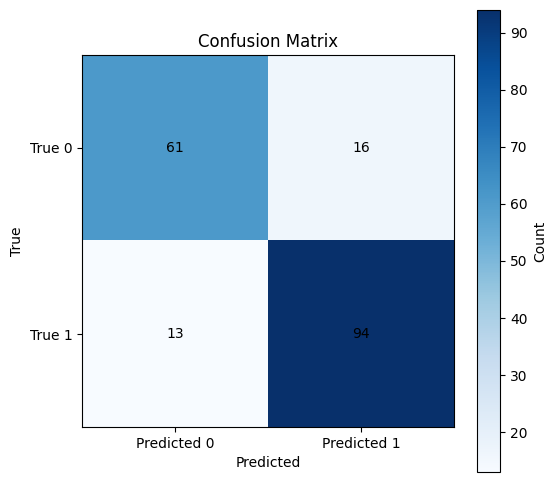

F1-Score: 0.866


In [12]:
best_idx = np.unravel_index(np.argmin(misclassification_errors, axis=None), misclassification_errors.shape)
best_max_depth = max_depths[best_idx[0]]
best_min_samples_split = min_samples_splits[best_idx[1]]
print(f"Best Max Depth: {best_max_depth}")
print(f"Best Min Samples Split: {best_min_samples_split}")

decision_tree_classifier = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_split=best_min_samples_split)
decision_tree_classifier.fit(X_train, y_train)
y_pred = decision_tree_classifier.predict(X_test)
misclassification_error = np.mean(y_pred != y_test)
print(f"Misclassification Error: {misclassification_error}")
accuracy_score = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_score}")
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)
f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1:.3f}")
